# Transfer Learning

from http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## Loading & prepare Data 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from torch.optim import lr_scheduler
from torch.autograd import Variable

from torchvision import models, transforms

import os
import time
import copy

import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = 'data/hymenoptera_data/'

# Compute general mean and std (for each channel)
images = datasets.ImageFolder(data_path + 'train', transforms.ToTensor())

mean = torch.stack([image.mean(1).mean(1) for image, t in images]).mean(0)
std = torch.stack([image.view(3, -1).std(1) for image, t in images]).mean(0)

In [3]:
# Create the complete image transformation function

input_size = 224 # pixel

data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(input_size),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)]),
    
    'test' : transforms.Compose([transforms.Resize(input_size + 20),
                                 transforms.CenterCrop(input_size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)])}

# Load datasets

image_datasets, dataloaders, datasets_sizes, = {}, {}, {}

for phase in ['train', 'test']:
    image_datasets[phase] = ImageFolder(data_path + phase, data_transforms[phase])
    dataloaders[phase] = DataLoader(image_datasets[phase], 
                                    batch_size=4, shuffle=True, num_workers=4)
    datasets_sizes[phase] = len(image_datasets[phase])
    
dataset_classes = image_datasets['train'].classes

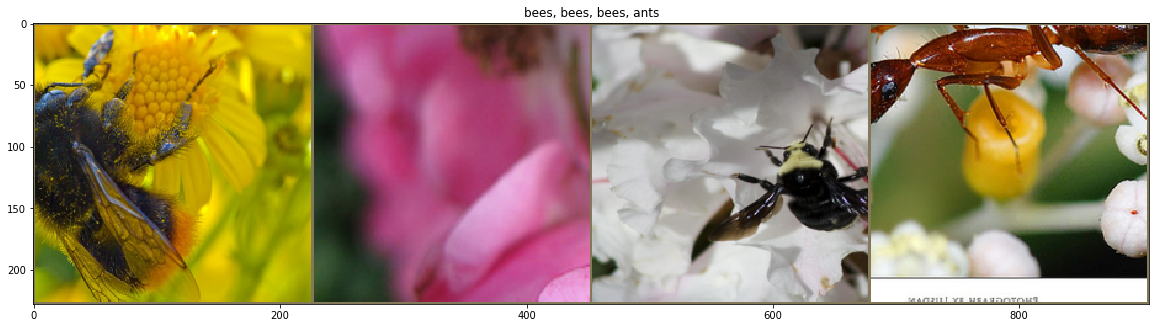

In [4]:
def images_show(data_loader, class_names, mean, std):
    """Imshow for Tensor."""
    
    if torch.is_tensor(mean): mean = mean.numpy()
    if torch.is_tensor(std): std = std.numpy()
        
    inputs, classes = next(iter(data_loader))
    
    output = torchvision.utils.make_grid(inputs)
    output = output.numpy().transpose((1, 2, 0))
    output = std * output + mean # Unnormalize
 
    plt.figure(figsize=(20,10))
    plt.imshow(output)
    plt.title(', '.join([class_names[class_] for class_ in classes]))
     
images_show(dataloaders['train'], dataset_classes, mean, std)

## Training and modelization

In [5]:
def train_model(model, dataloaders, dataset_size, criterion, 
                optimizer, scheduler, num_epochs=10):
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('-' * 20)
        print('Epoch %2d/%2d \n' % (epoch + 1, num_epochs))
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            
            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                # Forward
                outputs = model(inputs)
                _, prediction = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(prediction == labels.data)


            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects / dataset_size[phase]

            print('%5s  Loss: %.3f | Acc: %.3f' % (phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
         
        print()
    
    print('-' * 40)
    
    time_elapsed = time.time() - since
    print('Training complete in %.0fm %.0fs'%( time_elapsed // 60, time_elapsed % 60))
    
    print('Best val Acc: %.3f' % (best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

## Define the neural network

### Finetuning the convnet

Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

In [6]:
model_ft = models.resnet18(pretrained=True)

# Add of the full connected layers who 'requires_grad = True'
num_ftrs = model_ft.fc.in_features 
model_ft.fc = nn.Linear(num_ftrs, 2)

# Define new loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, dataloaders, datasets_sizes, criterion, optimizer_ft, exp_lr_scheduler)

### ConvNet as fixed feature extractor

We will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [7]:
model_ff = models.resnet18(pretrained=True)

# Block update of convNet parameters
for param in model_ff.parameters(): 
    param.requires_grad = False

# Capture the nb of enter on the full connected layer
num_ftrs = model_ff.fc.in_features 
# Create a new full connected layer but with only 2 outputs
model_ff.fc = nn.Linear(num_ftrs, 2)

# Define new loss function
criterion = nn.CrossEntropyLoss()

# Only train the fc layer
optimizer_ff = optim.SGD(model_ff.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ff, step_size=7, gamma=0.1)

In [8]:
model_ff = train_model(model_ff, dataloaders, datasets_sizes, criterion, optimizer_ff, exp_lr_scheduler)

--------------------
Epoch  1/10 

train  Loss: 0.655 | Acc: 0.660
 test  Loss: 0.350 | Acc: 0.856

--------------------
Epoch  2/10 

train  Loss: 0.563 | Acc: 0.758
 test  Loss: 0.260 | Acc: 0.902

--------------------
Epoch  3/10 

train  Loss: 0.381 | Acc: 0.844
 test  Loss: 0.230 | Acc: 0.922

--------------------
Epoch  4/10 

train  Loss: 0.373 | Acc: 0.836
 test  Loss: 0.204 | Acc: 0.928

--------------------
Epoch  5/10 

train  Loss: 0.330 | Acc: 0.840
 test  Loss: 0.195 | Acc: 0.935

--------------------
Epoch  6/10 

train  Loss: 0.520 | Acc: 0.791
 test  Loss: 0.238 | Acc: 0.922

--------------------
Epoch  7/10 

train  Loss: 0.449 | Acc: 0.832
 test  Loss: 0.343 | Acc: 0.876

--------------------
Epoch  8/10 

train  Loss: 0.387 | Acc: 0.848
 test  Loss: 0.223 | Acc: 0.915

--------------------
Epoch  9/10 

train  Loss: 0.282 | Acc: 0.877
 test  Loss: 0.195 | Acc: 0.922

--------------------
Epoch 10/10 

train  Loss: 0.406 | Acc: 0.840
 test  Loss: 0.181 | Acc: 0.928

